# Loads (Notice git integration)

In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 7.8MB/s 


In [0]:
import matplotlib

In [0]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.distributions import TransformedDistribution

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual





In [0]:
%matplotlib inline

In [5]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [6]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
#from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.flows import ConditionalNormalizingFlowWrapper, ConditionalAffineCoupling

# Load data

In [0]:
two_moons_folder = os.path.join(dataset_folder, 'two_moons')
csv_path = os.path.join(two_moons_folder, 'rotating_two_moons_no_moon_100k_n005.csv')
data_df = pd.read_csv(csv_path)


In [10]:
data_df

,x1,x2,theta
0,-0.302805,1.440689,4.861437
1,-0.569753,-1.165468,4.588591
2,-0.065869,-1.311738,5.019965
3,0.733455,-0.043946,4.253330
4,-0.214984,-0.679081,5.912119
...,...,...,...
99995,1.150161,-0.923861,2.463759
99996,-0.305002,-0.426768,2.725614
99997,-1.406495,-0.168755,0.288765
99998,-1.095531,0.247276,0.361811


# Train flow

In [0]:
import argparse
import pickle
import os
import pandas as pd

from DEwNF.flows import conditional_normalizing_flow_factory3
from DEwNF.utils import split_synthetic
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule

import torch.optim as optim
from time import time
from pyro.optim.clipped_adam import ClippedAdam

In [0]:
import itertools
import pyro.distributions as dist
from pyro.nn import DenseNN
from torch import nn
import torch
from pyro.distributions.transforms import permute, batchnorm, conditional_planar


class ConditionalNormalizingFlowWrapper3(object):
    def __init__(self, transforms, flow, base_dist, condinet, batchnorms=None):
        self.dist = dist.ConditionalTransformedDistribution(base_dist, flow)
        self.condinet = condinet
        self.modules = nn.ModuleList(transforms).append(self.condinet)

        if batchnorms is not None:
            self.modules = self.modules.extend(batchnorms)

    def condition(self, context):
        rich_context = self.condinet(context)
        conditioned_dist = self.dist.condition(rich_context)
        return conditioned_dist

    def cuda(self):
        self.modules.cuda()

def conditional_planar_flow_factory(flow_depth, problem_dim, context_n_h_dim,
                                    context_n_depth, rich_context_dim, nn_depth,
                                    nn_hidden_dim, batchnorm_momentum, cuda):
    if cuda:
        base_dist = dist.Normal(torch.zeros(problem_dim).cuda(), torch.ones(problem_dim).cuda())
    else:
        base_dist = dist.Normal(torch.zeros(problem_dim), torch.ones(problem_dim))

    # We define the transformations
    transforms = [conditional_planar(input_dim=problem_dim,
                                     context_dim=rich_context_dim,
                                     hidden_dims=[nn_hidden_dim for _ in range(nn_depth)])
                  for _ in range(flow_depth)]

    # If we want batchnorm add those in. Then sandwich the steps together to a flow
    if batchnorm_momentum is None:
        batchnorms = None
        flows = transforms
    else:
        batchnorms = [batchnorm(input_dim=problem_dim, momentum=batchnorm_momentum) for _ in range(flow_depth)]
        # We fix the gamma in the batchnorm
        for bn in batchnorms:
            bn.gamma.data += torch.ones(problem_dim)
        flows = list(itertools.chain(*zip(batchnorms, transforms)))[1:]

    # We define the conditioning network
    context_hidden_dims = [context_n_h_dim for i in range(context_n_depth)]
    condinet = DenseNN(input_dim=context_dim, hidden_dims=context_hidden_dims, param_dims=[rich_context_dim])


    # We define the normalizing flow wrapper
    normalizing_flow = ConditionalNormalizingFlowWrapper3(transforms, flows, base_dist, condinet, batchnorms)
    if cuda:
        normalizing_flow.cuda()

    return normalizing_flow


def conditional_normalizing_flow_factory3(flow_depth, problem_dim, c_net_depth, c_net_h_dim, context_dim,
                                          context_n_h_dim, context_n_depth, rich_context_dim, batchnorm_momentum, cuda,
                                          coupling_dropout=None, context_dropout=None):
    if cuda:
        base_dist = dist.Normal(torch.zeros(problem_dim).cuda(), torch.ones(problem_dim).cuda())
    else:
        base_dist = dist.Normal(torch.zeros(problem_dim), torch.ones(problem_dim))

    # We define the transformations
    transforms = [conditional_affine_coupling2(input_dim=problem_dim,
                                               context_dim=context_dim,
                                               hidden_dims=[c_net_h_dim for i in range(c_net_depth)], # Note array here to create multiple layers in DenseNN
                                               rich_context_dim=rich_context_dim,
                                               dropout=coupling_dropout)
                  for i in range(flow_depth)]


    # Permutes are needed to be able to transform all dimensions.
    # Note that the transform is fixed here since we only have 2 dimensions. For more dimensions don't fix it and let it be random.
    perms = [permute(input_dim=problem_dim, permutation=torch.tensor([1, 0])) for i in range(flow_depth)]

    # If we want batchnorm add those in. Then sandwich the steps together to a flow
    if batchnorm_momentum is None:
        batchnorms = None
        flows = list(itertools.chain(*zip(transforms, perms)))[:-1]
    else:
        batchnorms = [batchnorm(input_dim=problem_dim, momentum=batchnorm_momentum) for i in range(flow_depth)]
        for bn in batchnorms:
            bn.gamma.data += torch.ones(problem_dim)
        flows = list(itertools.chain(*zip(batchnorms, transforms, perms)))[1:-1]

    # We define the conditioning network
    context_hidden_dims = [context_n_h_dim for i in range(context_n_depth)]
    if context_dropout is None:
        condinet = DenseNN(input_dim=context_dim, hidden_dims=context_hidden_dims, param_dims=[rich_context_dim])
    else:
        condinet = DropoutDenseNN(input_dim=context_dim, hidden_dims=context_hidden_dims, param_dims=[rich_context_dim],
                                  dropout=context_dropout)
    # We define the normalizing flow wrapper
    normalizing_flow = ConditionalNormalizingFlowWrapper3(transforms, flows, base_dist, condinet, batchnorms)
    if cuda:
        normalizing_flow.cuda()

    return normalizing_flow


In [0]:
conditional_planar_flow_factory?

In [0]:
# cuda
cuda_exp = True

# Noise reg
noise_reg_schedule = constant_regularization_schedule
noise_reg_sigma = 0.04  # Used as sigma in rule of thumb and as noise in const

context_dropout = None
coupling_dropout = None
l2_reg = None

# Data settings
data_size = 100000

# Training settings
epochs = 3000
batch_size = 50000
clipped_adam = 10

# Dimensions of problem
problem_dim = 2

# Flow settings
flow_depth = 24
nn_depth = 2
nn_hidden_dim = 20

batchnorm_momentum = 0.1

# Define context conditioner
context_n_depth = 4
context_n_h_dim = 18
rich_context_dim = 5

settings_dict = {
    "epochs": epochs,
    "batch_size": batch_size,
    "problem_dim": problem_dim,
    "data_size": data_size,
    "flow_depth": flow_depth,
    "context_n_depth": context_n_depth,
    "context_n_h_dim": context_n_h_dim,
    "rich_context_dim": rich_context_dim,
    "context_dropout": context_dropout,
    "coupling_dropout": coupling_dropout,
    "l2_reg": l2_reg,
    "clipped_adam": clipped_adam,
    "batchnorm_momentum": batchnorm_momentum
}



In [0]:
import argparse
import pickle
import os
import pandas as pd

from DEwNF.flows import conditional_normalizing_flow_factory3
from DEwNF.utils import split_synthetic
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule

import torch.optim as optim
from time import time
from pyro.optim.clipped_adam import ClippedAdam

In [0]:
from tqdm import tqdm

In [0]:
# Load data
train_dataloader, test_dataloader = split_synthetic(data_df, batch_size,
                                                    data_size, cuda_exp, random_state=None)

context_dim = len(data_df.columns) - 2

In [0]:
# Define normalizing flow
normalizing_flow = conditional_planar_flow_factory(flow_depth=flow_depth,
                                                   problem_dim=problem_dim,
                                                   nn_depth=nn_depth,
                                                   nn_hidden_dim=nn_hidden_dim,
                                                    context_n_h_dim=context_n_h_dim,
                                                    context_n_depth=context_n_depth,
                                                    rich_context_dim=rich_context_dim,
                                                    cuda=cuda_exp,
                                                    batchnorm_momentum=batchnorm_momentum)

In [66]:
# Define stuff for reqularization
data_size = len(train_dataloader)
data_dim = problem_dim + context_dim



# Setup Optimizer
if clipped_adam is None:
    if l2_reg is None:
        optimizer = optim.Adam(normalizing_flow.modules.parameters(), lr=1e-4)
    else:
        optimizer = optim.Adam(normalizing_flow.modules.parameters(), lr=1e-4, weight_decay=l2_reg)
else:
    if l2_reg is None:
        optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=1e-4, clip_norm=clipped_adam)
    else:
        optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=1e-4, weight_decay=l2_reg,
                                clip_norm=clipped_adam)

# Setup regularization
h = noise_reg_schedule(data_size, data_dim, noise_reg_sigma)
noise_reg = NoiseRegularizer(discrete_dims=None, h=h, cuda=cuda_exp)

# Train and test sizes
n_train = train_dataloader.dataset.shape[0]
n_test = test_dataloader.dataset.shape[0]

# Training loop
full_train_losses = []
train_losses = []
test_losses = []
no_noise_losses = []

for epoch in tqdm(range(1, epochs + 1)):

    normalizing_flow.modules.train()
    train_epoch_loss = 0
    for k, batch in enumerate(train_dataloader):
        # Add noise reg to two moons
        batch = noise_reg.add_noise(batch)
        x = batch[:, :problem_dim]
        context = batch[:, problem_dim:]

        # Condition the flow on the sampled covariate and calculate -log_prob = loss
        conditioned_flow_dist = normalizing_flow.condition(context)
        loss = -conditioned_flow_dist.log_prob(x).sum()

        # Calculate gradients and take an optimizer step
        normalizing_flow.modules.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    full_train_losses.append(train_epoch_loss / n_train)

    # save every 10 epoch to log and eval
    if epoch % 10 == 0 or epoch == epochs - 1:
        normalizing_flow.modules.eval()
        train_losses.append(train_epoch_loss / n_train)

        no_noise_epoch_loss = 0
        for k, batch in enumerate(train_dataloader):
            # Add noise reg to two moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            loss = -conditioned_flow_dist.log_prob(x).sum()

            no_noise_epoch_loss += loss.item()
        no_noise_losses.append(no_noise_epoch_loss / n_train)

        test_epoch_loss = 0
        for j, batch in enumerate(test_dataloader):
            # Sample covariates and use them to sample from conditioned two_moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            test_loss = -conditioned_flow_dist.log_prob(x).sum()

            test_epoch_loss += test_loss.item()
        test_losses.append(test_epoch_loss / n_test)

    # Plot Epoch results if epoch == epochs-1:
    if epoch == epochs - 1:
        normalizing_flow.modules.eval()
        print(f"Epoch {epoch}: train loss: {train_losses[-1]} no noise loss:{no_noise_losses[-1]} test_loss: {test_losses[-1]}")
experiment_dict = {'train': train_losses, 'test': test_losses, 'no_noise_losses': no_noise_losses}
bas
results_dict = {'model': normalizing_flow, 'settings': settings_dict, 'logs': experiment_dict}


  0%|          | 0/3000 [00:00<?, ?it/s]


KeyError: ignored

# Visualize training

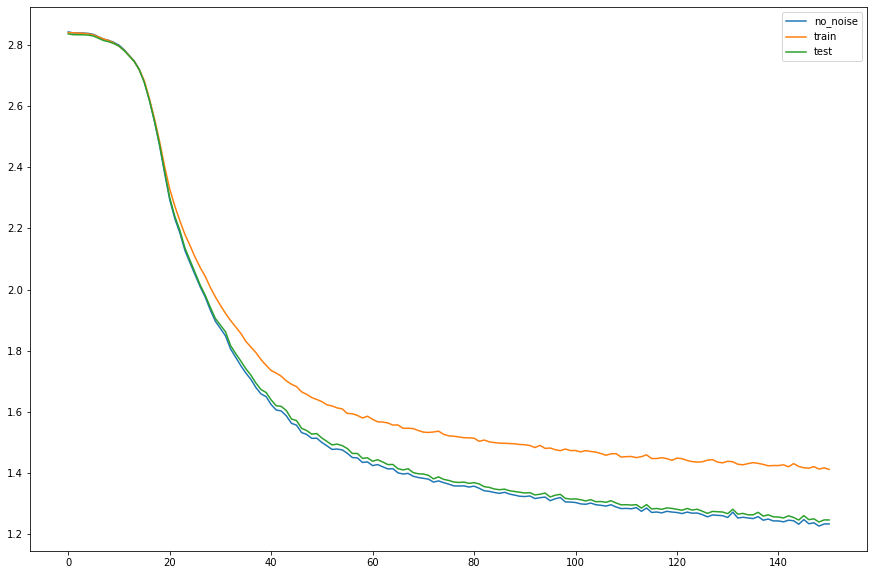

In [0]:
fig, ax = plt.subplots(1, figsize=(15,10))

ax.plot(no_noise_losses)
ax.plot(train_losses)
ax.plot(test_losses)
ax.legend(['no_noise', 'train', 'test'])

In [0]:
def create_overlay(shape, bounds, flow_dist):
    cm = matplotlib.cm.get_cmap('cividis')
    nlats, nlons = shape
    
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats).float()
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons).float()
    x, y = torch.meshgrid(lats_array, lons_array)

    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1).cuda()
    data = flow_dist.log_prob(points).reshape(nlats,nlons).cpu().detach().numpy()
    
    data = np.exp(data).T # this transpose should not be necesary
    data = (data - data.min()) / (data.max() - data.min())

    overlay = cm(data)
    return lons_array, lats_array, overlay

In [0]:
## interactive plot

cond_two_moons = RotatingTwoMoonsConditionalSampler(noise=0.05)

def model_tester3(theta, flow):
    theta = torch.tensor([theta])

    context = torch.tensor((theta)).unsqueeze(0).cuda()
    cond_dist = flow.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=theta)
    bounds = [[-6,-5], [6,5]]
    _,_, overlay = create_overlay(shape = (200,200), bounds=bounds, flow_dist = cond_dist)  
    x_s = cond_dist.sample((512,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c='r', s=5)
    plt.scatter(x_s[:, 0], x_s[:, 1], c='b', s=1)
    plt.xlim(-6,6)
    plt.ylim(-5,5)
    plt.imshow(overlay, extent=(6,-6, 5, -5))
    plt.show()


interactive_plot = interactive(model_tester3,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow))
interactive_plot




interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:
def create_plot(axs, x, dist, trans_idx, trans_type):
    bounds = [[-6,-5], [6,5]]
    _,_, overlay = create_overlay(shape = (200,200), bounds=bounds, flow_dist = dist)  
    x_s = dist.sample((521,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    axs.scatter(x[:, 0], x[:, 1], c='r', s=5)
    axs.scatter(x_s[:, 0], x_s[:, 1], c='b', s=1, alpha=0.1)
    axs.set_xlim(-6,6)
    axs.set_ylim(-5,5)
    axs.set_title(f'After transformation number {trans_idx} ({trans_type})')

    axs.imshow(overlay, extent=(6,-6, 5, -5))


In [0]:
def model_tester4(theta, moon, flow):
    theta = torch.tensor([theta])
    moon = torch.tensor([moon])
    context = torch.cat((theta, moon)).unsqueeze(0).cuda()
    cond_dist = flow.condition(context)


    x, _= cond_two_moons.conditioned_sample(n_samples=512, theta=theta)
    bounds = [[-6,-5], [6,5]]
    n_trans = len(cond_dist.transforms)
    fig, axs = plt.subplots((n_trans+1) // 2 , 2,  figsize=(20,n_trans*5))

    create_plot(axs[0, 0], x, cond_dist.base_dist.to_event(1), 0, 'Base distribution')
    for i in range(0, n_trans):
        temp_dist = TransformedDistribution(cond_dist.base_dist, cond_dist.transforms[0:i+1])
        trans_type = cond_dist.transforms[i].__str__()
        create_plot(axs[(i+1) // 2, (i+1) % 2 ], x, temp_dist, i+1, trans_type)



interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               moon=(0.,1.,1),
                               flow=fixed(loaded_flow))
interactive_plot


NameError: ignored

In [0]:

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               moon=(0.,1.,1),
                               trans_1=(-4.,4.),
                               trans_2=(-4.,4.),
                               flow_dist=fixed(loaded_flow.dist))
interactive_plot


In [0]:
model_tester4(0.,0.,0.,0.,loaded_flow.dist)

In [0]:
model_tester4(1.,1.,2.,-2.,loaded_flow.dist)

# Test with newer model

In [0]:
file_name = 'old_flows/c_nf_two_moon_proper_covariate_training.pickle'
file_path = os.path.join(trained_flows_folder, file_name)
with open(file_path, 'rb') as f:

    loaded_flow = pickle.load(f)

In [0]:
def create_overlay2(shape, bounds, flow_dist):
    cm = matplotlib.cm.get_cmap('cividis')
    nlats, nlons = shape
    
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats).float()
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons).float()
    x, y = torch.meshgrid(lats_array, lons_array)

    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1)
    data = flow_dist.log_prob(points).reshape(nlats,nlons).cpu().detach().numpy()
    
    data = np.exp(data).T # this transpose should not be necesary
    data = (data - data.min()) / (data.max() - data.min())

    overlay = cm(data)
    return lons_array, lats_array, overlay

def model_tester4(theta, flow):
    theta = torch.tensor([theta])

    context = torch.tensor((theta)).unsqueeze(0)
    cond_dist = flow.dist.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=theta)
    bounds = [[-6,-5], [6,5]]
    _,_, overlay = create_overlay2(shape = (200,200), bounds=bounds, flow_dist = cond_dist)  
    x_s = cond_dist.sample((512,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c='r', s=5)
    plt.scatter(x_s[:, 0], x_s[:, 1], c='b', s=1)
    plt.xlim(-6,6)
    plt.ylim(-5,5)
    plt.imshow(overlay, extent=(6,-6, 5, -5))
    plt.show()

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               flow=fixed(loaded_flow))
interactive_plot


interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

# TEST

In [0]:
# cuda
cuda_exp = True

# Noise reg
noise_reg_schedule = constant_regularization_schedule
noise_reg_sigma = 0.00  # Used as sigma in rule of thumb and as noise in const

context_dropout = None
coupling_dropout = None
l2_reg = None

# Data settings
data_size = 100000

# Training settings
epochs = 1000
batch_size = 30000
clipped_adam = 10

# Dimensions of problem
problem_dim = 2

# Flow settings
flow_depth = 10
c_net_depth = 4
c_net_h_dim = 18
batchnorm_momentum = 0.1

# Define context conditioner
context_n_depth = 4
context_n_h_dim = 10
rich_context_dim = 5

settings_dict = {
    "epochs": epochs,
    "batch_size": batch_size,
    "problem_dim": problem_dim,
    "data_size": data_size,
    "flow_depth": flow_depth,
    "c_net_depth": c_net_depth,
    "c_net_h_dim": c_net_h_dim,
    "context_n_depth": context_n_depth,
    "context_n_h_dim": context_n_h_dim,
    "rich_context_dim": rich_context_dim,
    "context_dropout": context_dropout,
    "coupling_dropout": coupling_dropout,
    "l2_reg": l2_reg,
    "clipped_adam": clipped_adam,
    "batchnorm_momentum": batchnorm_momentum
}



In [0]:
# Define stuff for reqularization
data_size = len(train_dataloader)
data_dim = problem_dim + context_dim

# Define normalizing flow
normalizing_flow = conditional_normalizing_flow_factory3(flow_depth=flow_depth,
                                                            problem_dim=problem_dim,
                                                            c_net_depth=c_net_depth,
                                                            c_net_h_dim=c_net_h_dim,
                                                            context_dim=context_dim,
                                                            context_n_h_dim=context_n_h_dim,
                                                            context_n_depth=context_n_depth,
                                                            rich_context_dim=rich_context_dim,
                                                            cuda=cuda_exp,
                                                            coupling_dropout=coupling_dropout,
                                                            context_dropout=context_dropout,
                                                            batchnorm_momentum=batchnorm_momentum)

# Setup Optimizer

optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=1e-4, clip_norm=clipped_adam)

# Setup regularization
h = noise_reg_schedule(data_size, data_dim, noise_reg_sigma)
noise_reg = NoiseRegularizer(discrete_dims=None, h=h, cuda=cuda_exp)

# Train and test sizes
n_train = train_dataloader.dataset.shape[0]
n_test = test_dataloader.dataset.shape[0]

# Training loop
full_train_losses = []
train_losses = []
test_losses = []
no_noise_losses = []

normalizing_flow.modules.train()
for k in tqdm(range(1000)):
    
    # Sample covariates and use them to sample from conditioned two_moons
    time1 = time()
    x, y, theta = cond_two_moons.joint_sample(128)
    
    # Condition the flow on the sampled covariate and calulate -log_prob = loss
    time2 = time()
    conditioned_flow_dist = normalizing_flow.condition(theta.cuda())
    loss = -conditioned_flow_dist.log_prob(x.cuda()).sum()

    # Calculate gradients and take an optimizer step
    time3 = time()
    normalizing_flow.modules.zero_grad()
    loss.backward()
    optimizer.step()

    # If plotting iteration plot
    if k % 500 == 0:
        time4 = time()
        normalizing_flow.modules.eval()
        clear_output(wait=True)
        print(f"{k}: {loss.item()}")
        # plot_samples(conditioned_flow_dist,x) todo work on a plot # Plot does not work very well with the joint sampling scheme. It's a TODO to make a better plotting.
        time5 = time()
        print(
            f"Time spent \n Sampling: {time2 - time1} \n Calculating loss: {time3 - time2} \n Gradient step: {time4 - time3} \n Plot: {time5 - time4}"
        )
        normalizing_flow.modules.train()



 50%|█████     | 502/1000 [00:42<00:43, 11.46it/s]

500: 273.3257141113281
Time spent 
 Sampling: 0.015078544616699219 
 Calculating loss: 0.022990942001342773 
 Gradient step: 0.05276966094970703 
 Plot: 0.001932382583618164



100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]


In [0]:
## interactive plot

cond_two_moons = RotatingTwoMoonsConditionalSampler()

def model_tester3(theta, flow):
    theta = torch.tensor([theta])

    context = torch.tensor((theta)).unsqueeze(0).cuda()
    cond_dist = flow.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=theta)
    bounds = [[-6,-5], [6,5]]
    _,_, overlay = create_overlay(shape = (200,200), bounds=bounds, flow_dist = cond_dist)  
    x_s = cond_dist.sample((512,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c='r', s=5)
    plt.scatter(x_s[:, 0], x_s[:, 1], c='b', s=1)
    plt.xlim(-6,6)
    plt.ylim(-5,5)
    plt.imshow(overlay, extent=(6,-6, 5, -5))
    plt.show()


interactive_plot = interactive(model_tester3,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow))
interactive_plot




interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:
    normalizing_flow.modules.train()
    train_epoch_loss = 0
    for k, batch in enumerate(train_dataloader):
        # Add noise reg to two moons
        batch = noise_reg.add_noise(batch)
        x = batch[:, :problem_dim]
        context = batch[:, problem_dim:]

        # Condition the flow on the sampled covariate and calculate -log_prob = loss
        conditioned_flow_dist = normalizing_flow.condition(context)
        loss = -conditioned_flow_dist.log_prob(x).sum()

        # Calculate gradients and take an optimizer step
        normalizing_flow.modules.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    full_train_losses.append(train_epoch_loss / n_train)

    # save every 10 epoch to log and eval
    if epoch % 10 == 0 or epoch == epochs - 1:
        normalizing_flow.modules.eval()
        train_losses.append(train_epoch_loss / n_train)

        no_noise_epoch_loss = 0
        for k, batch in enumerate(train_dataloader):
            # Add noise reg to two moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            loss = -conditioned_flow_dist.log_prob(x).sum()

            no_noise_epoch_loss += loss.item()
        no_noise_losses.append(no_noise_epoch_loss / n_train)

        test_epoch_loss = 0
        for j, batch in enumerate(test_dataloader):
            # Sample covariates and use them to sample from conditioned two_moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            test_loss = -conditioned_flow_dist.log_prob(x).sum()

            test_epoch_loss += test_loss.item()
        test_losses.append(test_epoch_loss / n_test)

    # Plot Epoch results if epoch == epochs-1:
    if epoch == epochs - 1:
        normalizing_flow.modules.eval()
        print(f"Epoch {epoch}: train loss: {train_losses[-1]} no noise loss:{no_noise_losses[-1]} test_loss: {test_losses[-1]}")
experiment_dict = {'train': train_losses, 'test': test_losses, 'no_noise_losses': no_noise_losses}
bas
results_dict = {'model': normalizing_flow, 'settings': settings_dict, 'logs': experiment_dict}
